In [1]:
11

11

## 한글 font

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose   

## packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False) # 마이너스 부호 설정

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.utils import shuffle

In [4]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [5]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


In [6]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


In [7]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preprocessing


In [8]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['year'] = train['date'].dt.year 
train['month'] = train['date'].dt.month 
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek


train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['datetime64[ns]'])))
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']

imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)
imputed_train['day_of_week'] = imputed_train['day_of_week'].astype(int)
# train['rental'] = train['rental'].astype(float) # imputer가 rental을 float으로 바꾸었으므로 astype(float)을 하지 않아도 됀다.

train = imputed_train

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
 15  day_of_week    1026 non-null   int64  
dtypes: float64(12), int64(4)
memory usage: 128.4 KB


In [10]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['year'] = test['date'].dt.year 
test['month'] = test['date'].dt.month 
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek

imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['datetime64[ns]'])))
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']

imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)
imputed_test['day_of_week'] = imputed_test['day_of_week'].astype(int)

test = imputed_test

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
 14  day_of_week    365 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 42.9 KB


## EDA를 통한 모델 수정 1.ipynb 따라해보기

In [12]:
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018,1,1,0
1,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136.0,2018,1,2,1
2,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156.0,2018,1,3,2


### 렌탈계 이상치
- 정의 : 7000건 미만인 날 (임의로 지정)

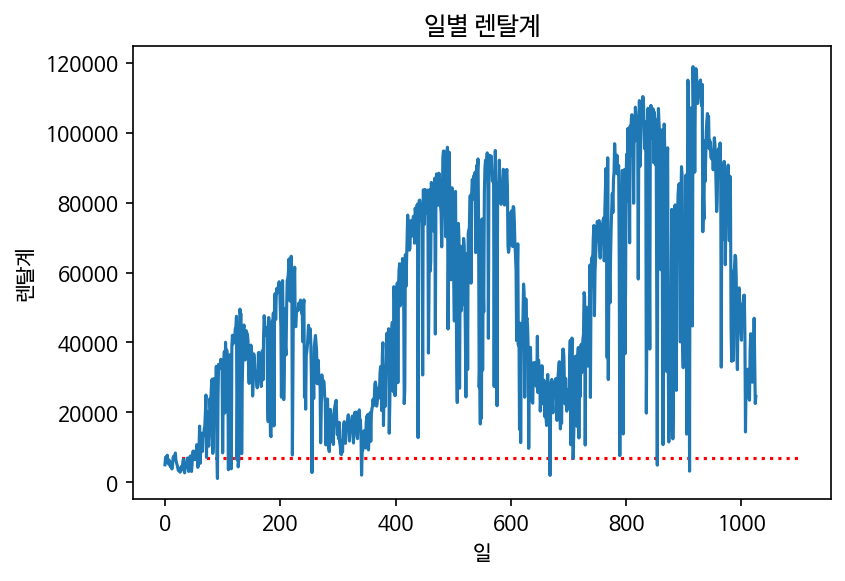

In [13]:
# 어떤 column이 렌탈계 이상치의 원인이라고 가정하자.
# train set에 있는 feature 15개 모두 test set에도 있다.
# 따라서 중식계 예측 모델에서 본사휴가자수 column을 제거하지 않은 것과 같이
# train set에 있는 어떤 column도 train set으로부터 drop시킬 수 없다.
plt.figure(dpi=150)
plt.title('일별 렌탈계')
plt.xlabel('일')
plt.ylabel('렌탈계')

plt.plot(train.index, train['rental'])
plt.hlines(y=7000, xmin=0, xmax=1100, color='red', linestyle='dotted')
plt.show()

#### 원인 탐색
- 어떤 column이 렌탈계 이상치를 유발했는지 살펴보자

In [14]:
train[train['rental'] < 7000].head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
0,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950.0,2018,1,1,0
5,0.0,-2.8,2.9,-6.8,38.0,27.0,45.8,8.8,90.7,1.5,3.1,5681.0,2018,1,6,5
6,0.0,-0.8,2.8,-5.7,47.0,36.0,42.1,3.1,32.0,0.8,2.5,5220.0,2018,1,7,6


In [15]:
train[train['rental'] < 7000].describe()

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.00000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,12.258929,0.030357,4.108929,-3.326786,36.839286,23.071429,57.70000,5.046429,49.135714,2.155357,4.621429,4612.071429,2018.160714,2.357143,13.571429,3.000000
std,24.142417,9.675459,9.001258,10.365897,19.465379,14.956734,22.15326,3.905472,38.054786,0.982931,1.495534,1442.603201,0.531782,2.186143,8.841755,2.199173
min,0.000000,-14.800000,-10.700000,-17.800000,8.000000,4.000000,26.90000,0.000000,0.000000,0.700000,1.700000,1037.000000,2018.000000,1.000000,1.000000,0.000000
25%,0.000000,-6.550000,-1.875000,-10.325000,26.750000,13.750000,40.02500,0.075000,0.525000,1.400000,3.400000,3538.000000,2018.000000,1.000000,7.000000,1.000000
50%,0.000000,-0.950000,3.800000,-5.400000,34.500000,19.000000,51.50000,6.050000,59.400000,1.850000,4.700000,4450.500000,2018.000000,2.000000,12.000000,3.000000
75%,5.650000,4.275000,7.700000,1.800000,45.500000,32.000000,75.25000,8.800000,86.925000,2.825000,5.625000,5776.000000,2018.000000,2.000000,21.250000,5.000000
max,83.500000,22.600000,26.900000,21.000000,99.000000,78.000000,97.00000,9.700000,90.700000,4.200000,8.000000,6993.000000,2020.000000,11.000000,31.000000,6.000000


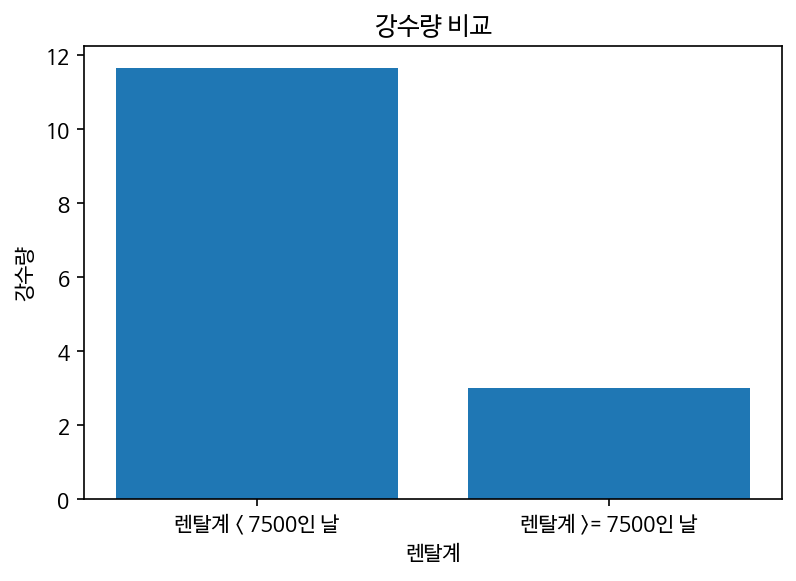

[11.669230769230769, 2.992299687825181]

In [16]:
# 관찰 : 미만인 날의 강수량이 이상인 날의 강수량보다 많다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['precipitation'].mean(),
     train[train['rental'] >= 7500]['precipitation'].mean()]

plt.figure(dpi=150)
plt.title('강수량 비교')
plt.xlabel('렌탈계')
plt.ylabel('강수량')

plt.bar(x,y)
plt.show()

y

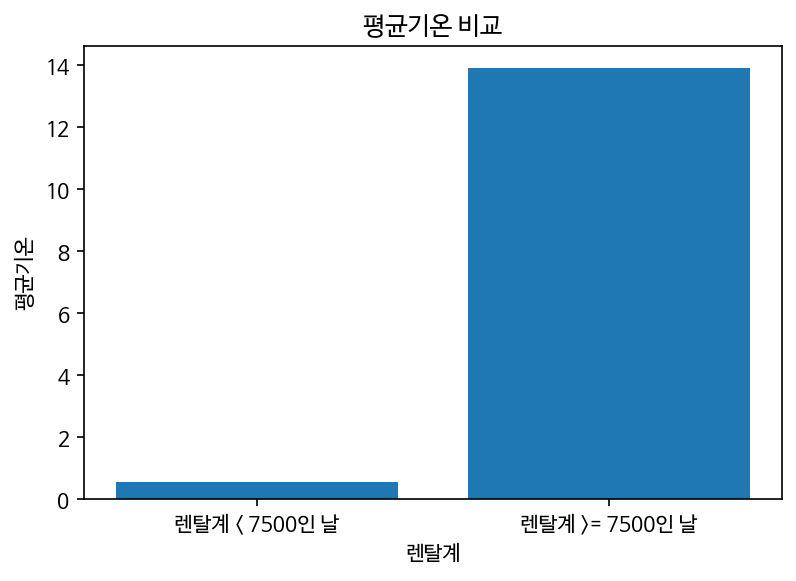

[0.5646153846153845, 13.926118626430798]

In [17]:
# 관찰 : 미만인 날의 평균기온이 이상인 날의 평균기온보다 낮다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_mean'].mean(),
     train[train['rental'] >= 7500]['temp_mean'].mean()]

plt.figure(dpi=150)
plt.title('평균기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('평균기온')

plt.bar(x,y)
plt.show()

y

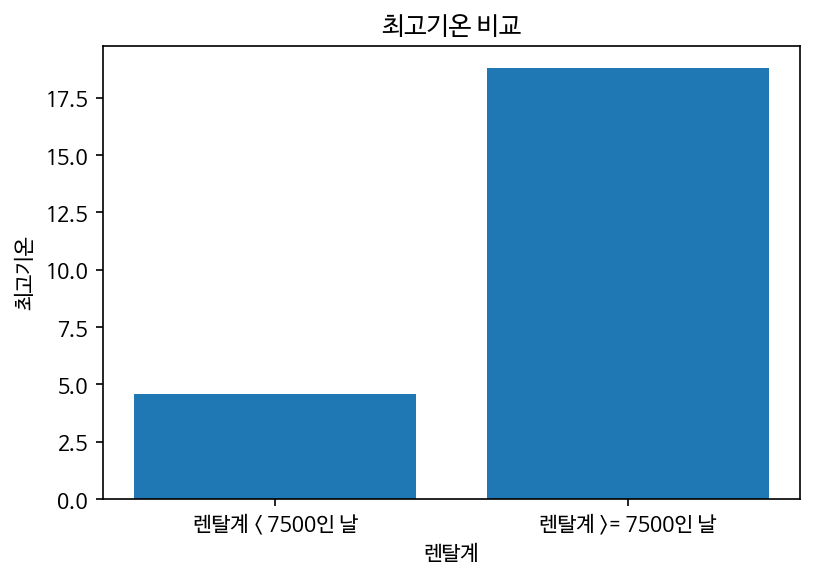

[4.6000000000000005, 18.814255983350666]

In [18]:
# 관찰 : 미만인 날의 최고기온이 이상인 날의 최고기온보다 낮다. 
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_highest'].mean(),
     train[train['rental'] >= 7500]['temp_highest'].mean()]

plt.figure(dpi=150)
plt.title('최고기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('최고기온')

plt.bar(x,y)
plt.show()

y

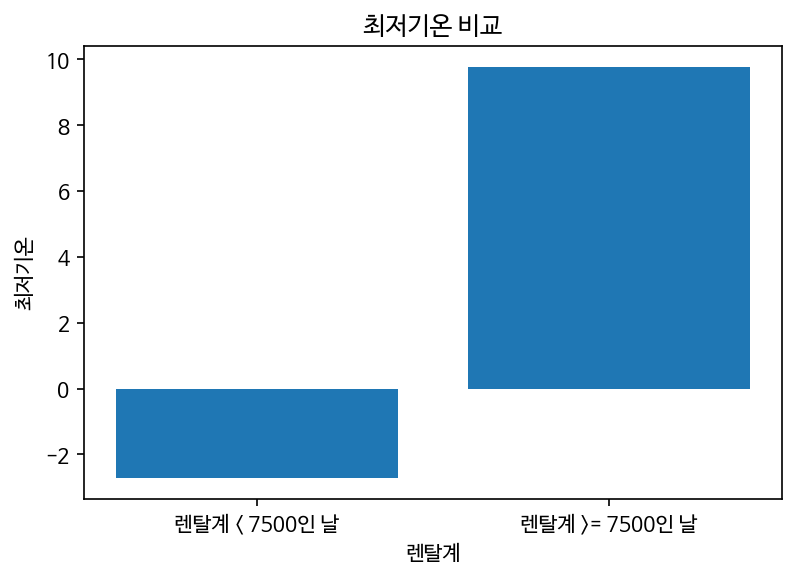

[-2.732307692307693, 9.775546305931323]

In [19]:
# 관찰 : 미만인 날의 최저기온이 이상인 날의 최저기온보다 낮다. 
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_lowest'].mean(),
     train[train['rental'] >= 7500]['temp_lowest'].mean()]

plt.figure(dpi=150)
plt.title('최저기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('최저기온')

plt.bar(x,y)
plt.show()

y

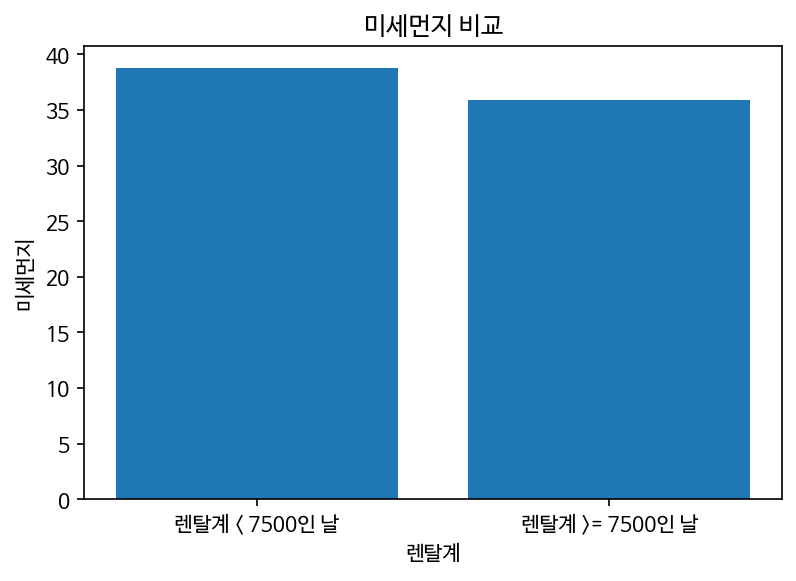

[38.815384615384616, 35.89594172736732]

In [20]:
# 관찰 : 미만인 날의 미세먼지가 이상인 날의 미세먼지보다 더 많다. 
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['PM10'].mean(),
     train[train['rental'] >= 7500]['PM10'].mean()]

plt.figure(dpi=150)
plt.title('미세먼지 비교')
plt.xlabel('렌탈계')
plt.ylabel('미세먼지')

plt.bar(x,y)
plt.show()

y

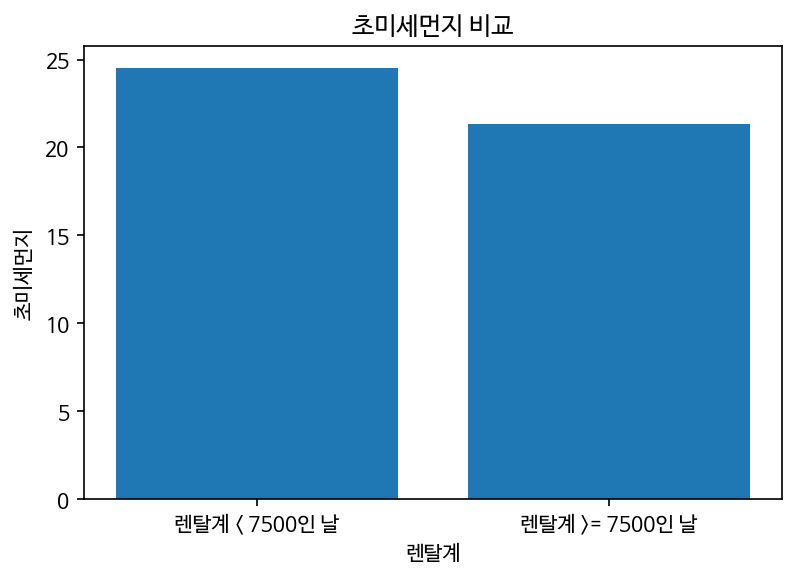

[24.53846153846154, 21.329864724245578]

In [21]:
# 관찰 : 미만인 날의 초미세먼지가 이상인 날의 초미세먼지보다 더 많다. 
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['PM2.5'].mean(),
     train[train['rental'] >= 7500]['PM2.5'].mean()]

plt.figure(dpi=150)
plt.title('초미세먼지 비교')
plt.xlabel('렌탈계')
plt.ylabel('초미세먼지')

plt.bar(x,y)
plt.show()

y

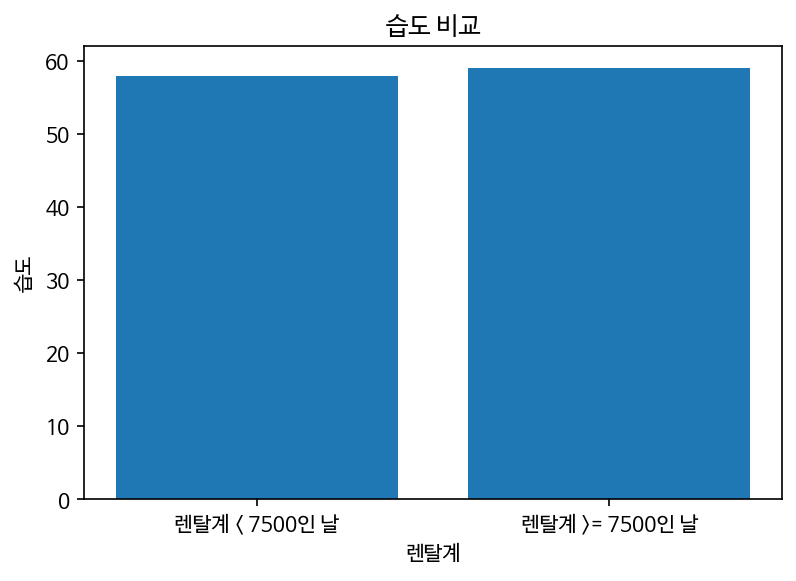

[57.90000000000001, 59.073569198751535]

In [22]:
# 관찰 : 미만인 날의 습도가 이상인 날의 습도보다 더 낮다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['humidity'].mean(),
     train[train['rental'] >= 7500]['humidity'].mean()]

plt.figure(dpi=150)
plt.title('습도 비교')
plt.xlabel('렌탈계')
plt.ylabel('습도')

plt.bar(x,y)
plt.show()

y

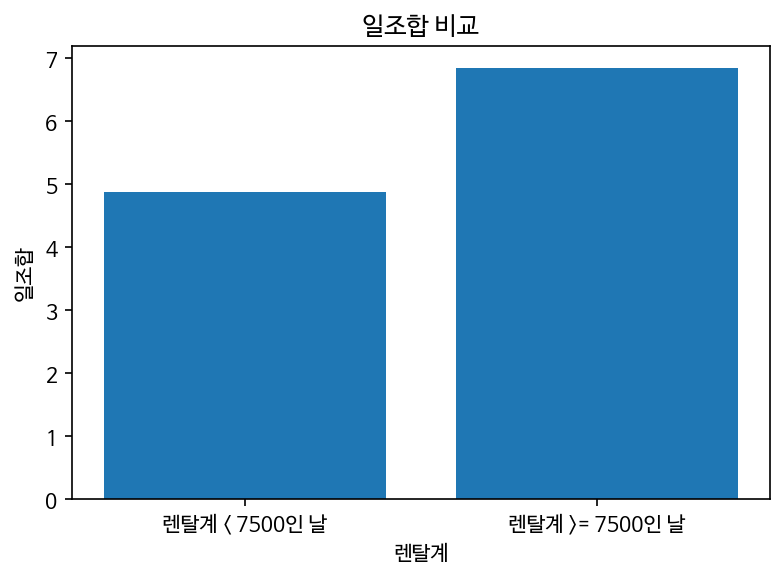

[4.872307692307693, 6.852653485952142]

In [23]:
# 관찰 : 미만인 날의 일조합이 이상인 날의 일조합보다 더 적다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['sunshine_sum'].mean(),
     train[train['rental'] >= 7500]['sunshine_sum'].mean()]

plt.figure(dpi=150)
plt.title('일조합 비교')
plt.xlabel('렌탈계')
plt.ylabel('일조합')

plt.bar(x,y)
plt.show()

y

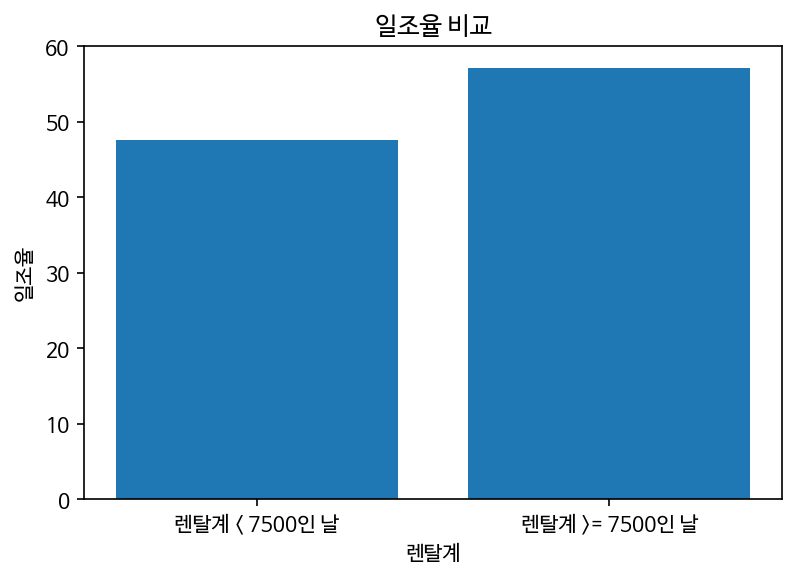

[47.54, 57.161810613943864]

In [24]:
# 관찰 : 미만인 날의 일조율이 이상인 날의 일조율보다 더 낮다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['sunshine_rate'].mean(),
     train[train['rental'] >= 7500]['sunshine_rate'].mean()]

plt.figure(dpi=150)
plt.title('일조율 비교')
plt.xlabel('렌탈계')
plt.ylabel('일조율')

plt.bar(x,y)
plt.show()

y

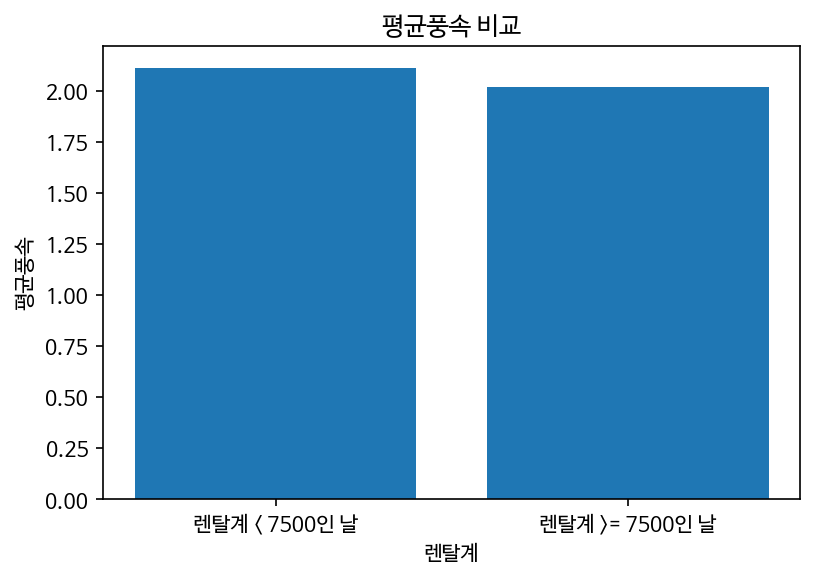

[2.1138461538461537, 2.018418314255983]

In [25]:
# 관찰 : 미만인 날의 평균풍속이 이상인 날의 평균풍속보다 더 높다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['wind_mean'].mean(),
     train[train['rental'] >= 7500]['wind_mean'].mean()]

plt.figure(dpi=150)
plt.title('평균풍속 비교')
plt.xlabel('렌탈계')
plt.ylabel('평균풍속')

plt.bar(x,y)
plt.show()

y

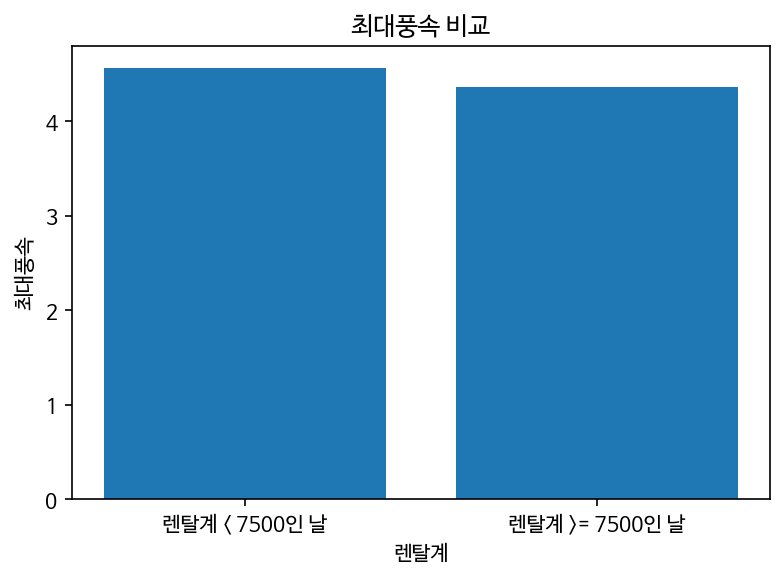

[4.567692307692307, 4.358376690946933]

In [26]:
# 관찰 : 미만인 날의 최대풍속이 이상인 날의 최대풍속보다 더 높다.
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['wind_max'].mean(),
     train[train['rental'] >= 7500]['wind_max'].mean()]

plt.figure(dpi=150)
plt.title('최대풍속 비교')
plt.xlabel('렌탈계')
plt.ylabel('최대풍속')

plt.bar(x,y)
plt.show()

y

####  잠정적 원인
1. 강수량
2. 평균기온
3. 최고기온
4. 최저기온

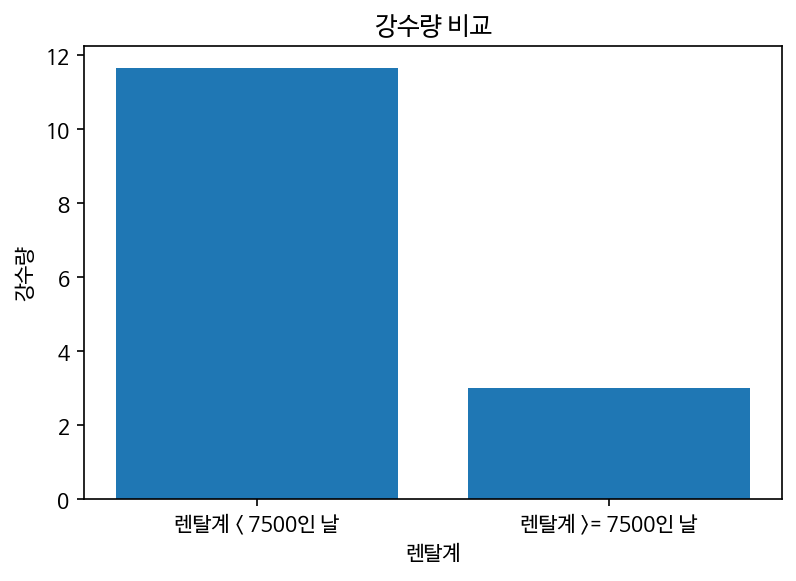

In [27]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['precipitation'].mean(),
     train[train['rental'] >= 7500]['precipitation'].mean()]

plt.figure(dpi=150)
plt.title('강수량 비교')
plt.xlabel('렌탈계')
plt.ylabel('강수량')

plt.bar(x,y)
plt.show()

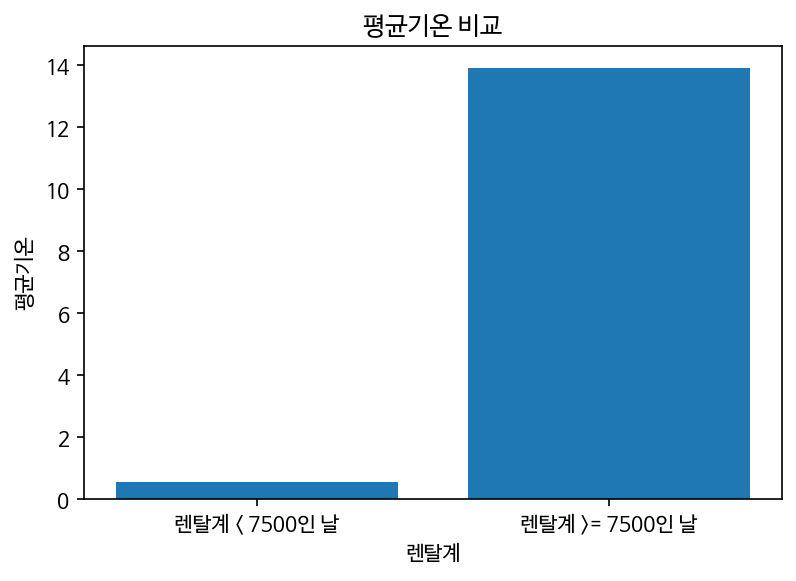

In [28]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_mean'].mean(),
     train[train['rental'] >= 7500]['temp_mean'].mean()]

plt.figure(dpi=150)
plt.title('평균기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('평균기온')

plt.bar(x,y)
plt.show()

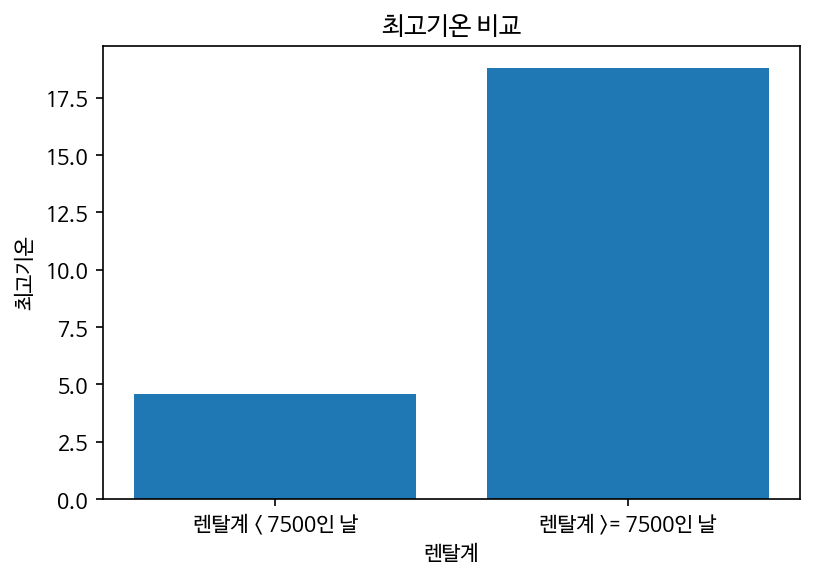

In [29]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_highest'].mean(),
     train[train['rental'] >= 7500]['temp_highest'].mean()]

plt.figure(dpi=150)
plt.title('최고기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('최고기온')

plt.bar(x,y)
plt.show()

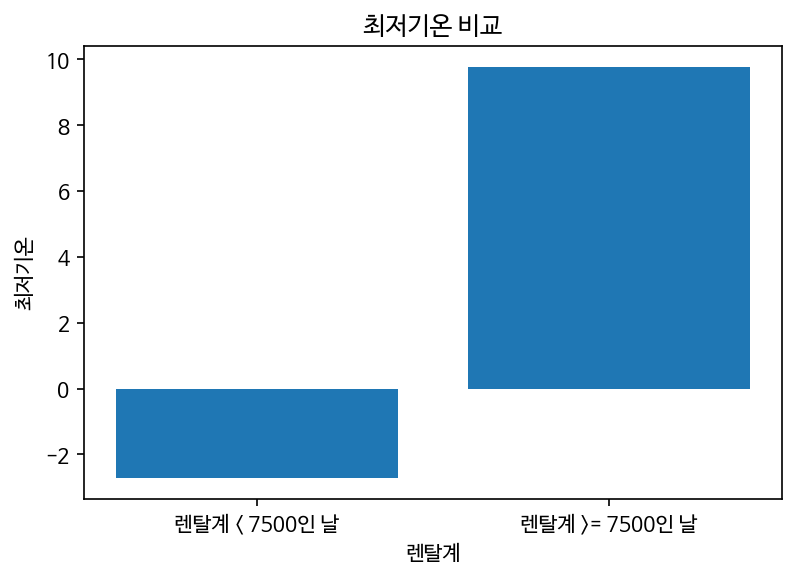

In [30]:
x = ['렌탈계 < 7500인 날', '렌탈계 >= 7500인 날']
y = [train[train['rental'] < 7500]['temp_lowest'].mean(),
     train[train['rental'] >= 7500]['temp_lowest'].mean()]

plt.figure(dpi=150)
plt.title('최저기온 비교')
plt.xlabel('렌탈계')
plt.ylabel('최저기온')

plt.bar(x,y)
plt.show()

### 렌탈계 분포

#### 연도별 분포
- 2020년이 가장 많다.
- 증가하는 경향을 보인다.

In [31]:
train.groupby('year').mean()[['rental']]

,rental
year,
2018,27106.860390
2019,52944.056497
2020,65004.315934


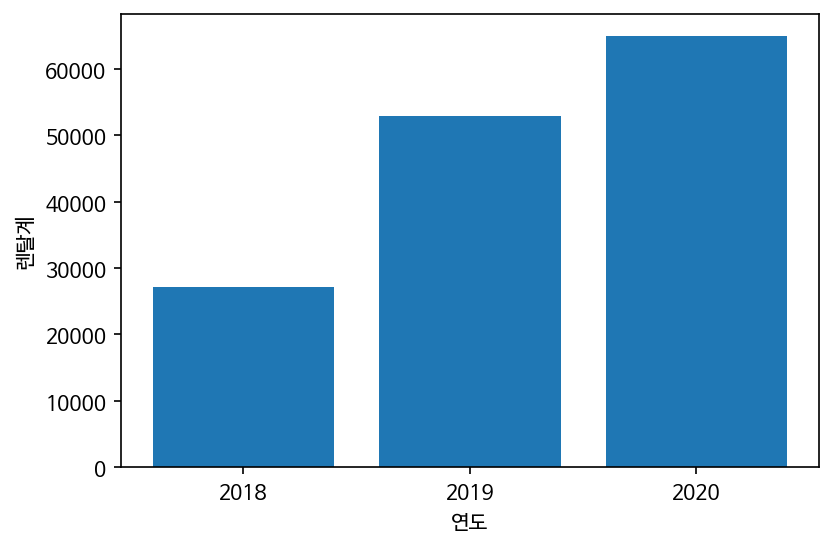

In [32]:
x = ['2018', '2019', '2020']
y = [train.groupby('year').mean()['rental'][2018],
     train.groupby('year').mean()['rental'][2019],
     train.groupby('year').mean()['rental'][2020]]
plt.figure(dpi=150)
plt.xlabel('연도')
plt.ylabel('렌탈계')
plt.bar(x, y)
plt.show()

#### 월별 분포
- 6월달에 가장 많다.
- 1월달에 가장 적다.

In [33]:
train.groupby('month').mean()[['rental']]

,rental
month,
1,15635.505376
2,16531.890244
3,33280.240000
4,51160.049383
5,64329.746988
6,79362.626866
7,63752.500000
8,52458.532609
9,71501.704545


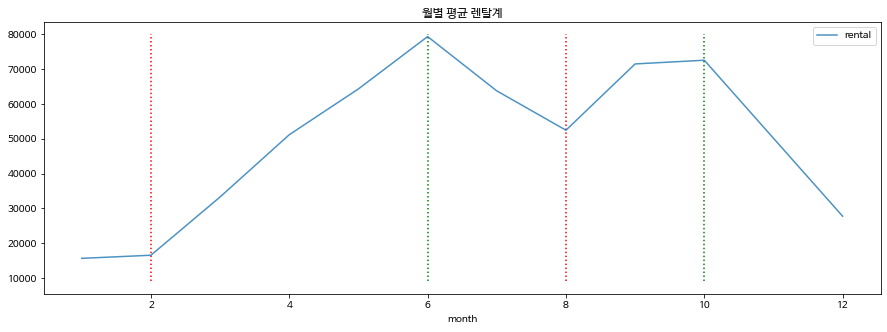

In [34]:
# red   : 증가하기 시작
# green : 감소하기 시작
train.groupby('month').mean()[['rental']].plot(figsize=(15,5), alpha=0.8)
plt.vlines(x=2, ymin=9000, ymax=80000, color='red', linestyle='dotted')
plt.vlines(x=6, ymin=9000, ymax=80000, color='green', linestyle='dotted')
plt.vlines(x=8, ymin=9000, ymax=80000, color='red', linestyle='dotted')
plt.vlines(x=10, ymin=9000, ymax=80000, color='green', linestyle='dotted')
plt.title('월별 평균 렌탈계')
plt.show()

#### 일별 분포

In [35]:
train.groupby('day').mean()[['rental']]

,rental
day,
1,47964.342857
2,45439.200000
3,49230.500000
4,50949.242424
5,49412.235294
6,46370.647059
7,46474.060606
8,50672.666667
9,46732.941176


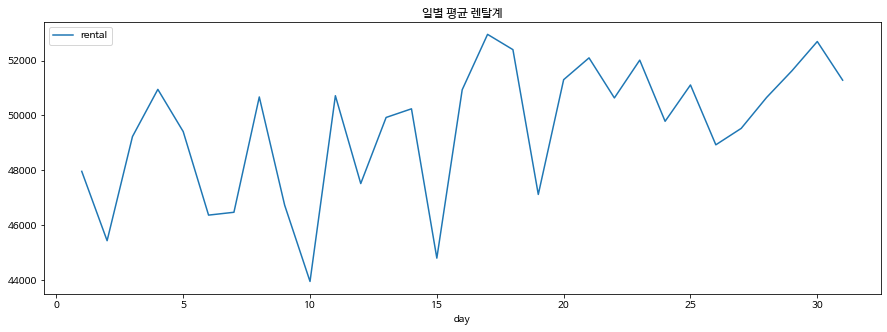

In [36]:
train.groupby('day').mean()[['rental']].plot(figsize=(15,5))
plt.title('일별 평균 렌탈계')
plt.show()

#### 요일별 분포
- 금요일에 가장 많다.
- 일요일에 가장 적다.

In [37]:
train.groupby('day_of_week').mean()[['rental']]

,rental
day_of_week,
0,48667.794702
1,51657.726667
2,49254.801370
3,50155.884354
4,51916.986395
5,49672.559441
6,44761.232394


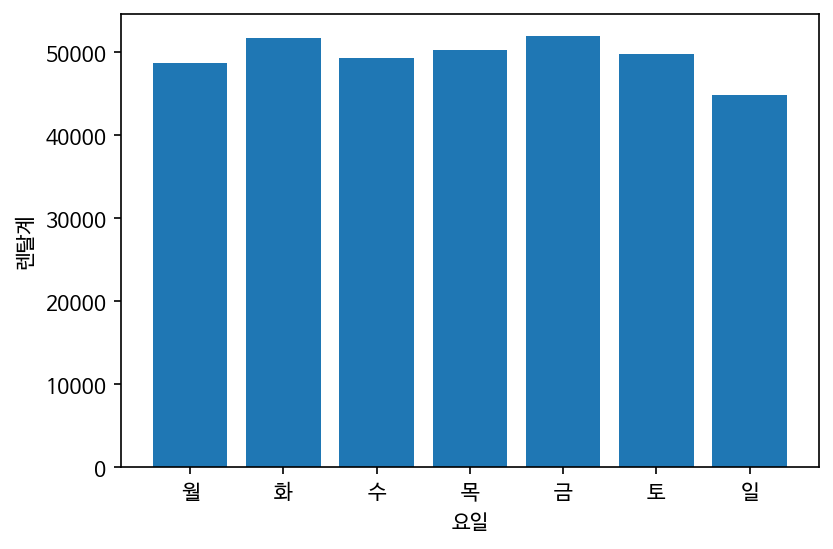

In [38]:
x = ['월', '화', '수', '목', '금', '토', '일']
y = [train.groupby('day_of_week').mean()['rental'][0],
     train.groupby('day_of_week').mean()['rental'][1],
     train.groupby('day_of_week').mean()['rental'][2],
     train.groupby('day_of_week').mean()['rental'][3],
     train.groupby('day_of_week').mean()['rental'][4],
     train.groupby('day_of_week').mean()['rental'][5],
     train.groupby('day_of_week').mean()['rental'][6],
     ]
plt.figure(dpi=150)
plt.xlabel('요일')
plt.ylabel('렌탈계')
plt.bar(x, y)
plt.show()

#### 결론 
- 연도별, 월별, 일별, 그리고 요일별로 서로 다른 분포를 보인다. 
- 따라서 year, month, day, day of week column을 train set과 test set에 추가한다.

## EDA를 통한 모델 수정 2.ipynb 따라해보기

### 강수량 분포
- 강수량 = 강우량 + 강설량

In [39]:
train['precipitation'].describe()

count    1026.000000
mean        3.542008
std        12.205196
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max       103.100000
Name: precipitation, dtype: float64

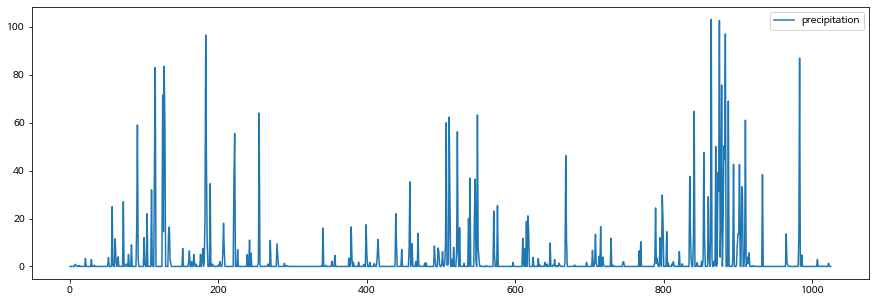

In [40]:
# 추측 : 여름에 강수량이 집중되어 있다.
train[['precipitation']].plot(figsize=(15,5))
plt.show()

#### 연도별 분포

In [41]:
train.groupby('year').mean()[['precipitation']]

,precipitation
year,
2018,3.674675
2019,2.413277
2020,4.527473


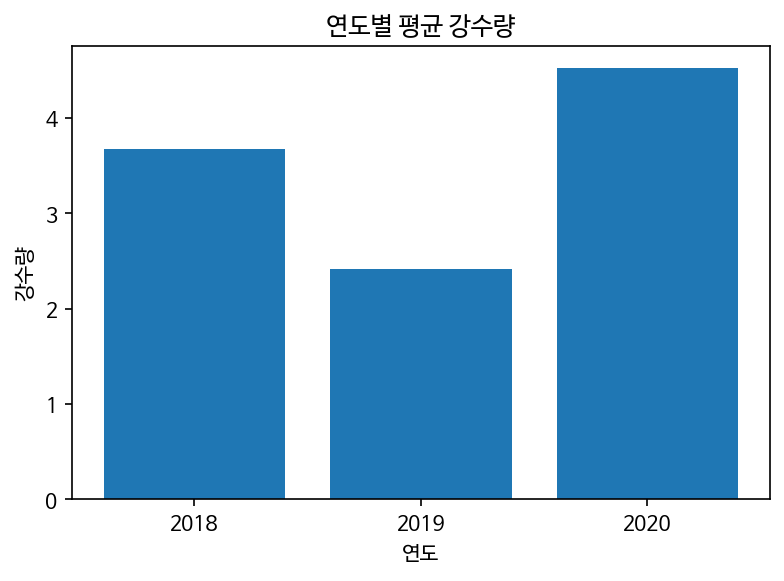

In [42]:
# 관찰 : 2019년도에 강수량이 가장 적었고 2020년도에 가장 많았다. (cf. 2019년 가뭄)
x = ['2018', '2019', '2020']
y = [train.groupby('year').mean()['precipitation'][2018],
     train.groupby('year').mean()['precipitation'][2019],
     train.groupby('year').mean()['precipitation'][2020]]
plt.figure(dpi=150)
plt.xlabel('연도')
plt.ylabel('강수량')
plt.title('연도별 평균 강수량')
plt.bar(x, y)
plt.show()

#### 월별 분포

In [43]:
train.groupby('month').mean()[['precipitation']]

,precipitation
month,
1,0.741935
2,1.260976
3,1.221333
4,1.922222
5,4.165060
6,4.471642
7,6.936667
8,11.523913
9,4.397727


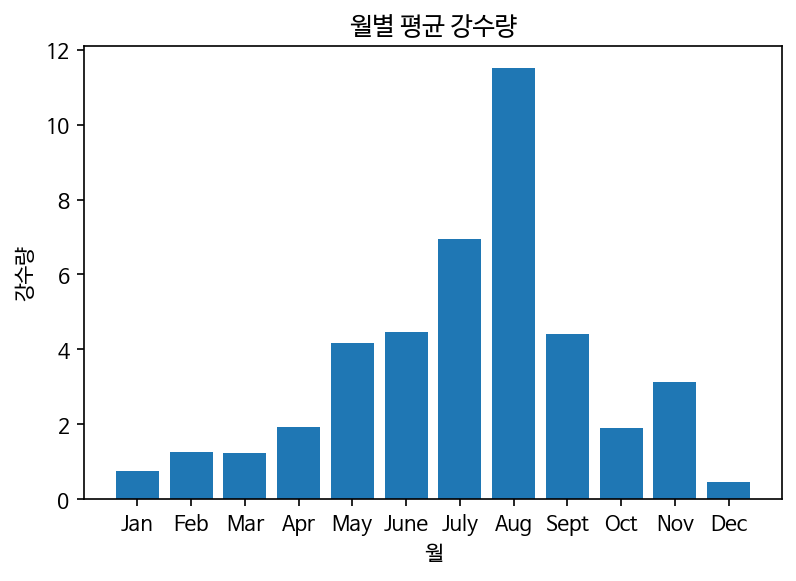

In [44]:
# 추측이 참임을 확인 : 강수량이 여름철에 집중되어 있다. 
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['precipitation'][1],
     train.groupby('month').mean()['precipitation'][2],
     train.groupby('month').mean()['precipitation'][3],
     train.groupby('month').mean()['precipitation'][4],
     train.groupby('month').mean()['precipitation'][5],
     train.groupby('month').mean()['precipitation'][6],
     train.groupby('month').mean()['precipitation'][7],
     train.groupby('month').mean()['precipitation'][8],
     train.groupby('month').mean()['precipitation'][9],
     train.groupby('month').mean()['precipitation'][10],
     train.groupby('month').mean()['precipitation'][11],
     train.groupby('month').mean()['precipitation'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('강수량')
plt.title('월별 평균 강수량')
plt.bar(x, y)
plt.show()

### 평균기온 분포

In [45]:
train['temp_mean'].describe()

count    1026.000000
mean       13.079630
std        10.585795
min       -14.800000
25%         4.500000
50%        13.500000
75%        22.600000
max        33.700000
Name: temp_mean, dtype: float64

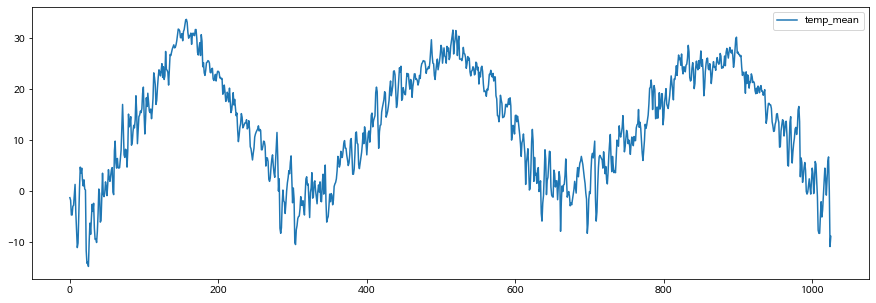

In [46]:
# 추측 : 여름철 평균 기온이 가장 높다.
train[['temp_mean']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

In [47]:
train.groupby('month').mean()[['temp_mean']]

,temp_mean
month,
1,-1.082796
2,0.628049
3,7.406667
4,12.120988
5,18.455422
6,23.237313
7,25.930000
8,27.481522
9,21.768182


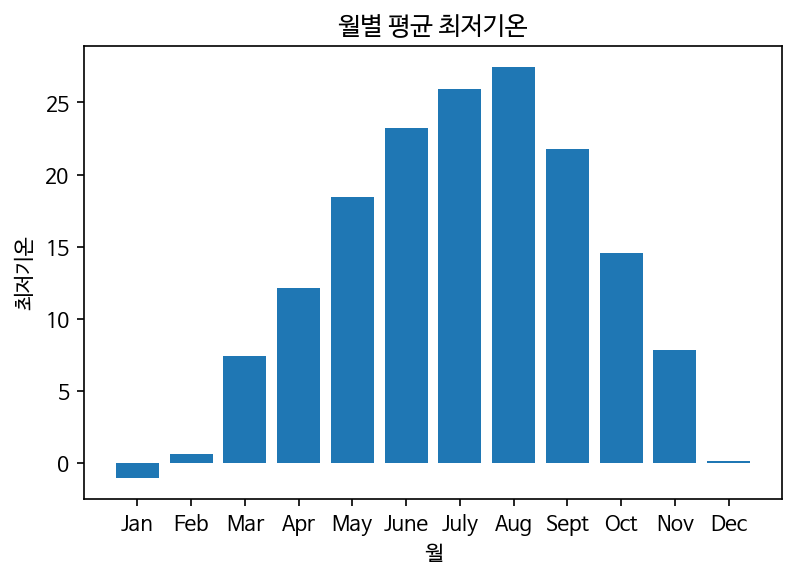

In [48]:
# 추측이 참임을 확인 : January가 가장 낮고 August가 가장 높다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['temp_mean'][1],
     train.groupby('month').mean()['temp_mean'][2],
     train.groupby('month').mean()['temp_mean'][3],
     train.groupby('month').mean()['temp_mean'][4],
     train.groupby('month').mean()['temp_mean'][5],
     train.groupby('month').mean()['temp_mean'][6],
     train.groupby('month').mean()['temp_mean'][7],
     train.groupby('month').mean()['temp_mean'][8],
     train.groupby('month').mean()['temp_mean'][9],
     train.groupby('month').mean()['temp_mean'][10],
     train.groupby('month').mean()['temp_mean'][11],
     train.groupby('month').mean()['temp_mean'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('최저기온')
plt.title('월별 평균 최저기온')
plt.bar(x, y)
plt.show()

### 최고기온 분포

In [49]:
train['temp_highest'].describe()

count    1026.000000
mean       17.913743
std        10.668069
min       -10.700000
25%         8.900000
50%        19.150000
75%        26.975000
max        39.600000
Name: temp_highest, dtype: float64

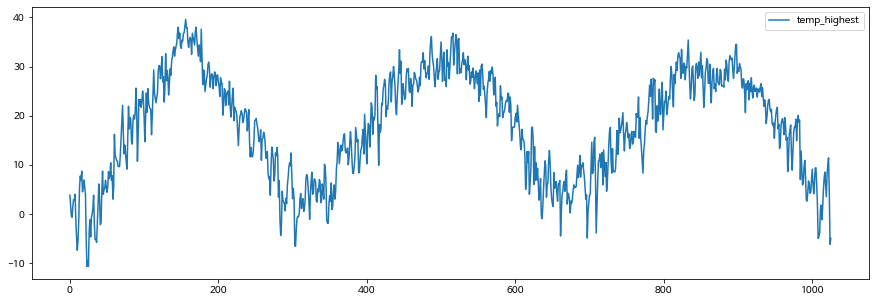

In [50]:
train[['temp_highest']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

In [51]:
train.groupby('month').mean()[['temp_highest']]

,temp_highest
month,
1,3.376344
2,5.525610
3,12.813333
4,17.785185
5,23.987952
6,28.414925
7,30.077778
8,31.389130
9,26.188636


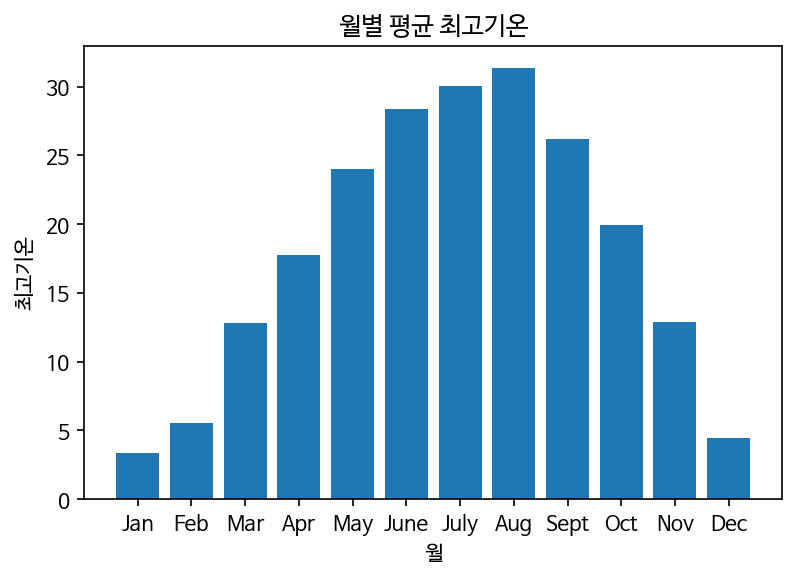

In [52]:
# 관찰 : January가 가장 낮고 August가 가장 높다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['temp_highest'][1],
     train.groupby('month').mean()['temp_highest'][2],
     train.groupby('month').mean()['temp_highest'][3],
     train.groupby('month').mean()['temp_highest'][4],
     train.groupby('month').mean()['temp_highest'][5],
     train.groupby('month').mean()['temp_highest'][6],
     train.groupby('month').mean()['temp_highest'][7],
     train.groupby('month').mean()['temp_highest'][8],
     train.groupby('month').mean()['temp_highest'][9],
     train.groupby('month').mean()['temp_highest'][10],
     train.groupby('month').mean()['temp_highest'][11],
     train.groupby('month').mean()['temp_highest'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('최고기온')
plt.title('월별 평균 최고기온')
plt.bar(x, y)
plt.show()

### 최저기온 분포

In [53]:
train['temp_lowest'].describe()

count    1026.000000
mean        8.983138
std        10.766636
min       -17.800000
25%         0.225000
50%         8.700000
75%        18.800000
max        30.300000
Name: temp_lowest, dtype: float64

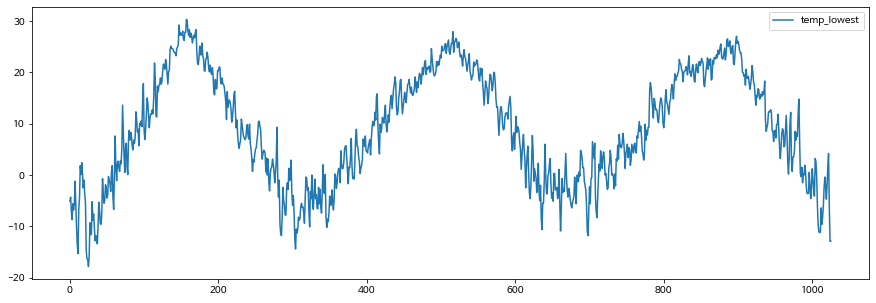

In [54]:
train[['temp_lowest']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

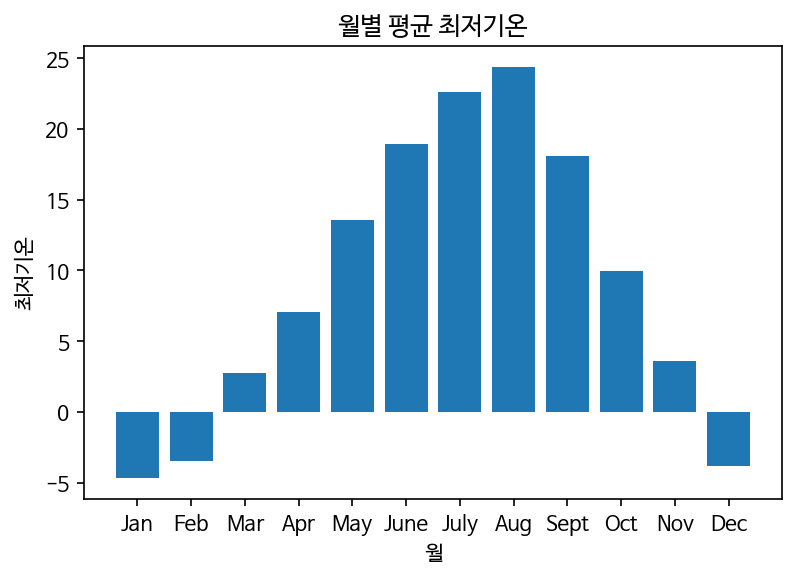

In [55]:
# 관찰 : January가 가장 낮고 August가 가장 높다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['temp_lowest'][1],
     train.groupby('month').mean()['temp_lowest'][2],
     train.groupby('month').mean()['temp_lowest'][3],
     train.groupby('month').mean()['temp_lowest'][4],
     train.groupby('month').mean()['temp_lowest'][5],
     train.groupby('month').mean()['temp_lowest'][6],
     train.groupby('month').mean()['temp_lowest'][7],
     train.groupby('month').mean()['temp_lowest'][8],
     train.groupby('month').mean()['temp_lowest'][9],
     train.groupby('month').mean()['temp_lowest'][10],
     train.groupby('month').mean()['temp_lowest'][11],
     train.groupby('month').mean()['temp_lowest'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('최저기온')
plt.title('월별 평균 최저기온')
plt.bar(x, y)
plt.show()

### 미세먼지 분포

In [56]:
train['PM10'].describe()

count    1026.000000
mean       36.080897
std        20.008249
min         5.000000
25%        23.000000
50%        32.000000
75%        45.000000
max       171.000000
Name: PM10, dtype: float64

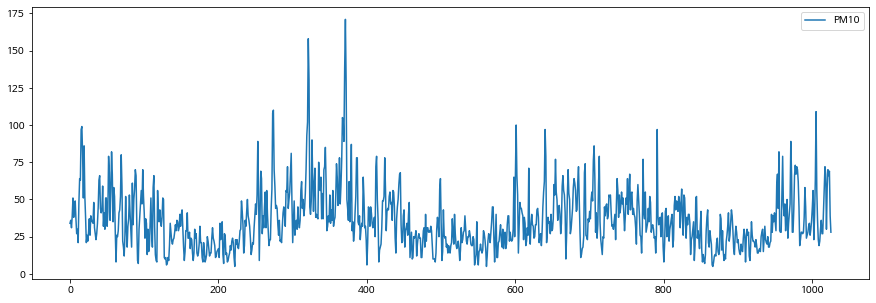

In [57]:
train[['PM10']].plot(figsize=(15,5))
plt.show()

#### 연도별 분포

In [58]:
train.groupby('year').mean()[['PM10']]

,PM10
year,
2018,34.237013
2019,37.779661
2020,35.989011


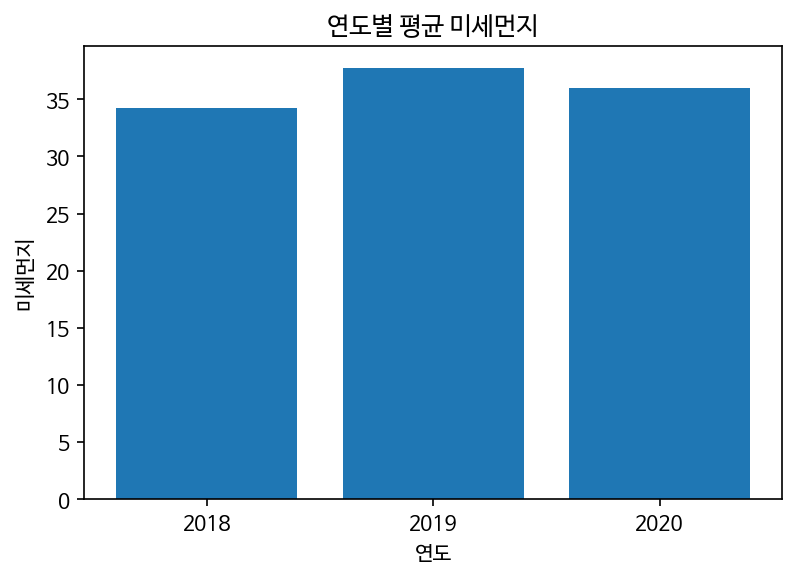

In [59]:
# 관찰 : 2019년에 미세먼지가 가장 많았다.
x = ['2018', '2019', '2020']
y = [train.groupby('year').mean()['PM10'][2018],
     train.groupby('year').mean()['PM10'][2019],
     train.groupby('year').mean()['PM10'][2020]]
plt.figure(dpi=150)
plt.xlabel('연도')
plt.ylabel('미세먼지')
plt.title('연도별 평균 미세먼지')
plt.bar(x, y)
plt.show()

#### 월별 분포

In [60]:
train.groupby('month').mean()[['PM10']]

,PM10
month,
1,49.387097
2,46.707317
3,48.506667
4,39.543210
5,37.493976
6,31.701493
7,23.577778
8,22.478261
9,19.784091


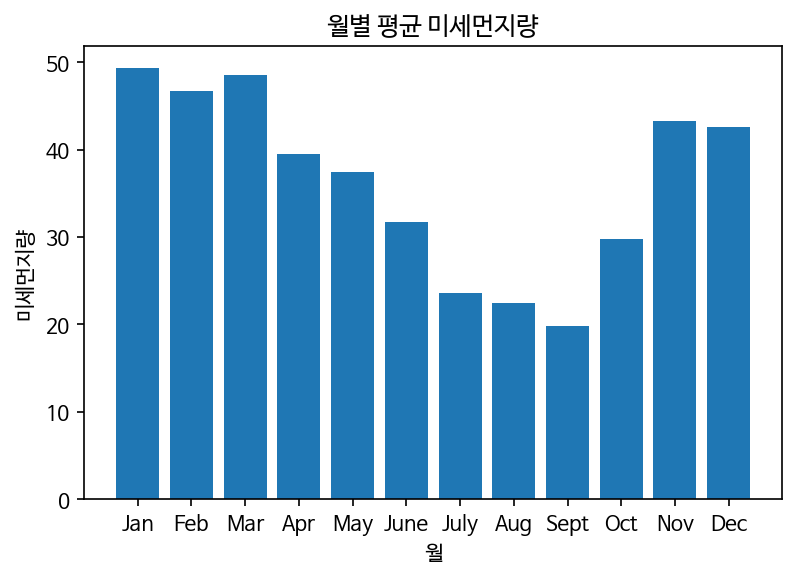

In [61]:
# 관찰 : 여름철에 미세먼지가 적다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['PM10'][1],
     train.groupby('month').mean()['PM10'][2],
     train.groupby('month').mean()['PM10'][3],
     train.groupby('month').mean()['PM10'][4],
     train.groupby('month').mean()['PM10'][5],
     train.groupby('month').mean()['PM10'][6],
     train.groupby('month').mean()['PM10'][7],
     train.groupby('month').mean()['PM10'][8],
     train.groupby('month').mean()['PM10'][9],
     train.groupby('month').mean()['PM10'][10],
     train.groupby('month').mean()['PM10'][11],
     train.groupby('month').mean()['PM10'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('미세먼지량')
plt.title('월별 평균 미세먼지량')
plt.bar(x, y)
plt.show()

### 초미세먼지 분포

In [62]:
train['PM2.5'].describe()

count    1026.000000
mean       21.533138
std        13.635584
min         2.000000
25%        12.000000
50%        19.000000
75%        27.000000
max       124.000000
Name: PM2.5, dtype: float64

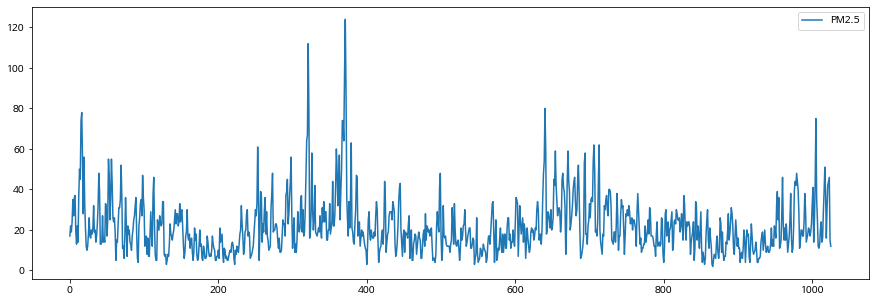

In [63]:
train[['PM2.5']].plot(figsize=(15,5))
plt.show()

#### 연도별 분포

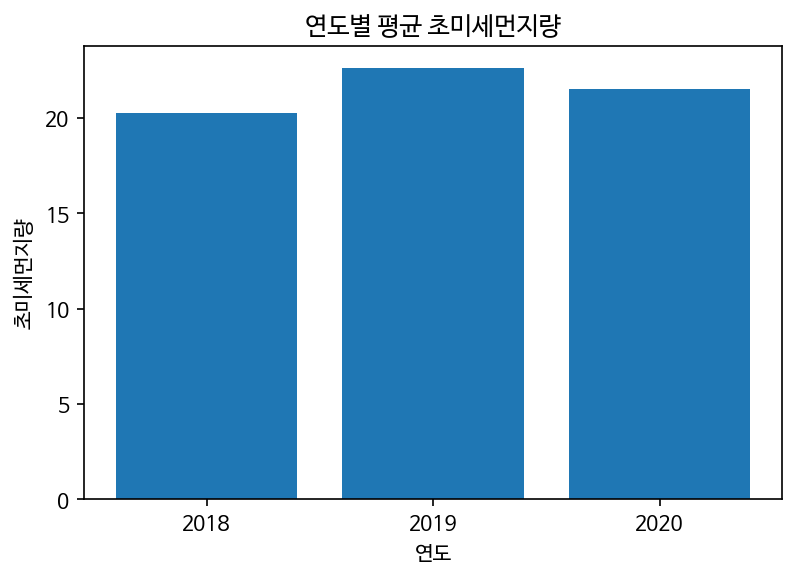

In [64]:
# 관찰 : 2019년도에 초미세먼지가 가장 많았다.
x = ['2018', '2019', '2020']
y = [train.groupby('year').mean()['PM2.5'][2018],
     train.groupby('year').mean()['PM2.5'][2019],
     train.groupby('year').mean()['PM2.5'][2020]]
plt.figure(dpi=150)
plt.xlabel('연도')
plt.ylabel('초미세먼지량')
plt.title('연도별 평균 초미세먼지량')
plt.bar(x, y)
plt.show()

#### 월별 분포

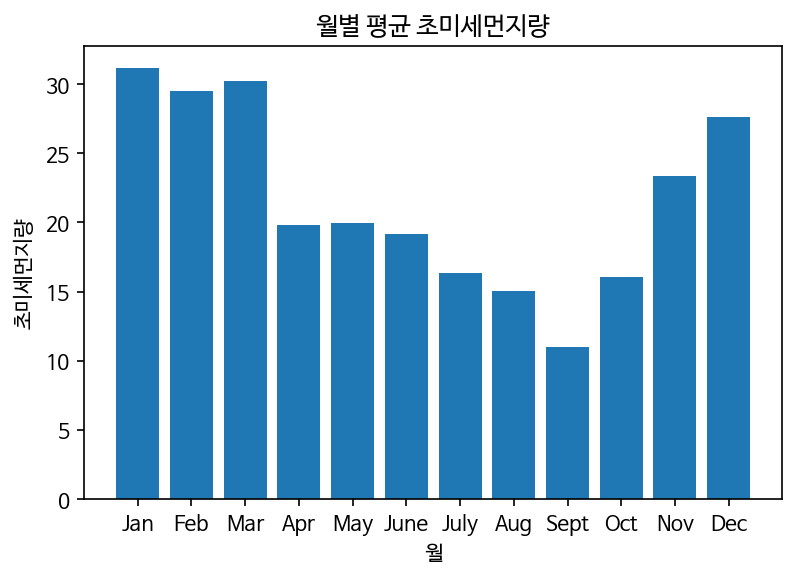

In [65]:
# 관찰 : September에 초미세먼지가 가장 적다.
# 관찰 : 미세먼지 월별 분포와는 조금 다른 분포를 보인다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['PM2.5'][1],
     train.groupby('month').mean()['PM2.5'][2],
     train.groupby('month').mean()['PM2.5'][3],
     train.groupby('month').mean()['PM2.5'][4],
     train.groupby('month').mean()['PM2.5'][5],
     train.groupby('month').mean()['PM2.5'][6],
     train.groupby('month').mean()['PM2.5'][7],
     train.groupby('month').mean()['PM2.5'][8],
     train.groupby('month').mean()['PM2.5'][9],
     train.groupby('month').mean()['PM2.5'][10],
     train.groupby('month').mean()['PM2.5'][11],
     train.groupby('month').mean()['PM2.5'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('초미세먼지량')
plt.title('월별 평균 초미세먼지량')
plt.bar(x, y)
plt.show()

- how to handle continuous feature

In [66]:
train.columns

Index(['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'rental', 'year', 'month', 'day', 'day_of_week'],
      dtype='object')

### 습도 분포

In [67]:
train['humidity'].describe()

count    1026.000000
mean       58.999220
std        15.826664
min        17.900000
25%        47.425000
50%        58.200000
75%        69.575000
max        97.000000
Name: humidity, dtype: float64

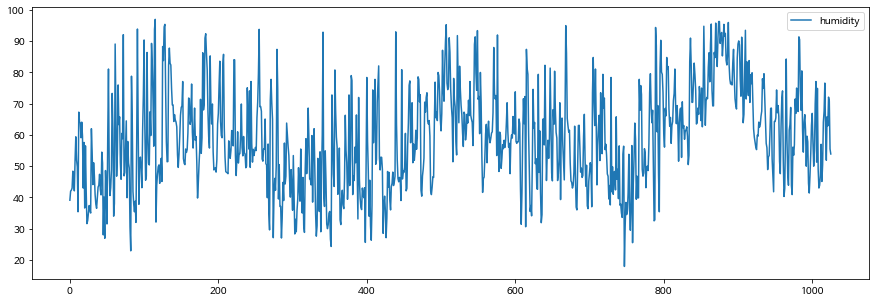

In [68]:
train[['humidity']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

In [69]:
train.groupby('month').mean()[['humidity']]

,humidity
month,
1,49.710753
2,50.334146
3,51.297333
4,50.376543
5,58.840964
6,63.501493
7,70.765556
8,72.752174
9,65.369318


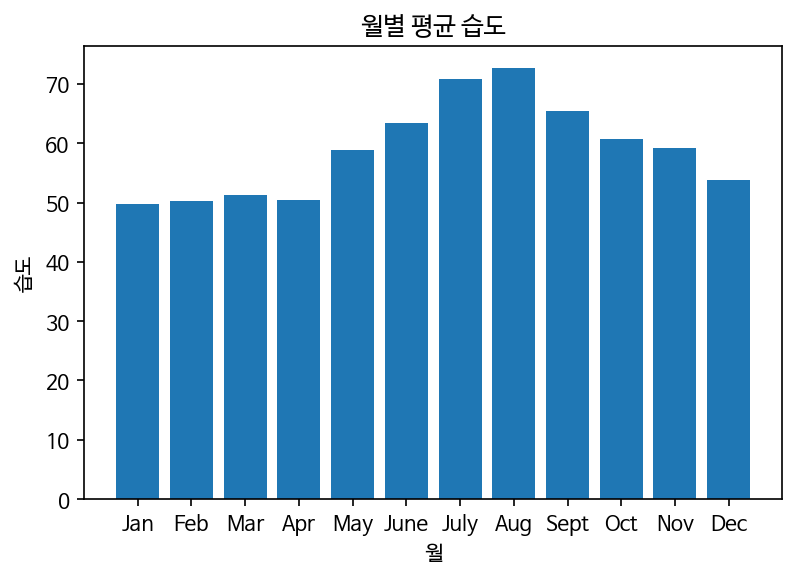

In [70]:
# 관찰 : 8월달이 가장 높다.
# 강수량과의 상관관계가 어떨지 궁금하다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['humidity'][1],
     train.groupby('month').mean()['humidity'][2],
     train.groupby('month').mean()['humidity'][3],
     train.groupby('month').mean()['humidity'][4],
     train.groupby('month').mean()['humidity'][5],
     train.groupby('month').mean()['humidity'][6],
     train.groupby('month').mean()['humidity'][7],
     train.groupby('month').mean()['humidity'][8],
     train.groupby('month').mean()['humidity'][9],
     train.groupby('month').mean()['humidity'][10],
     train.groupby('month').mean()['humidity'][11],
     train.groupby('month').mean()['humidity'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('습도')
plt.title('월별 평균 습도')
plt.bar(x, y)
plt.show()

### 일조합 분포

In [71]:
train['sunshine_sum'].describe()

count    1026.000000
mean        6.727193
std         3.981321
min         0.000000
25%         3.200000
50%         7.900000
75%         9.700000
max        13.600000
Name: sunshine_sum, dtype: float64

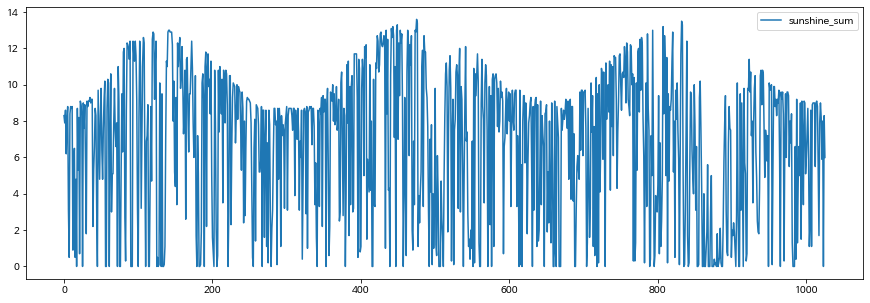

In [72]:
# 일조합 == 0 을 일조합 이상치로 취급해야하는가?
# 하루 종일 비가 오면 일조합이 0일까?
# 일조합 결측치를 0으로 대치하기는 했다.
train[['sunshine_sum']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

In [73]:
train.groupby('month').mean()[['sunshine_sum']]

,sunshine_sum
month,
1,6.232258
2,6.641463
3,7.352000
4,8.456790
5,7.610843
6,7.468657
7,5.421111
8,5.846739
9,6.369318


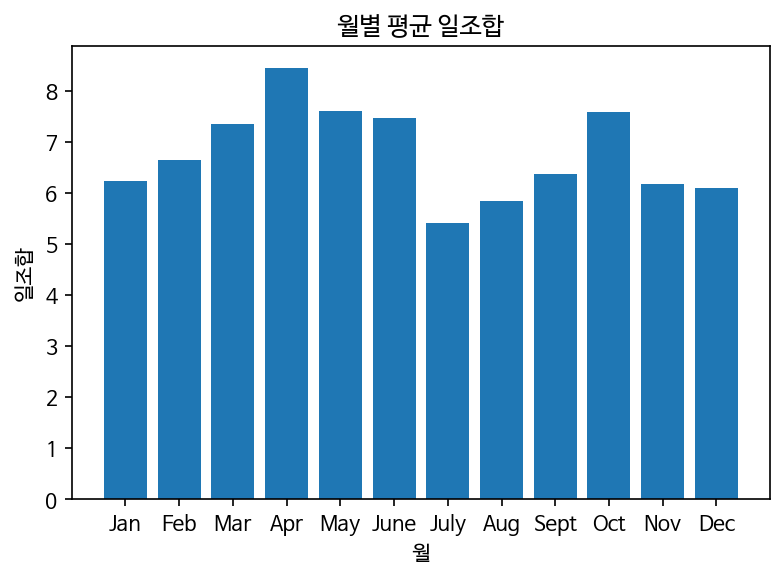

In [74]:
# 관찰 : 4월이 가장 많고 7월이 가장 적다.
# 강수량과의 상관관계가 어떨지 궁금하다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['sunshine_sum'][1],
     train.groupby('month').mean()['sunshine_sum'][2],
     train.groupby('month').mean()['sunshine_sum'][3],
     train.groupby('month').mean()['sunshine_sum'][4],
     train.groupby('month').mean()['sunshine_sum'][5],
     train.groupby('month').mean()['sunshine_sum'][6],
     train.groupby('month').mean()['sunshine_sum'][7],
     train.groupby('month').mean()['sunshine_sum'][8],
     train.groupby('month').mean()['sunshine_sum'][9],
     train.groupby('month').mean()['sunshine_sum'][10],
     train.groupby('month').mean()['sunshine_sum'][11],
     train.groupby('month').mean()['sunshine_sum'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('일조합')
plt.title('월별 평균 일조합')
plt.bar(x, y)
plt.show()

### 일조율 분포

In [75]:
train['sunshine_rate'].describe()

count    1026.000000
mean       56.552242
std        32.989082
min         0.000000
25%        25.950000
50%        67.300000
75%        86.500000
max        95.900000
Name: sunshine_rate, dtype: float64

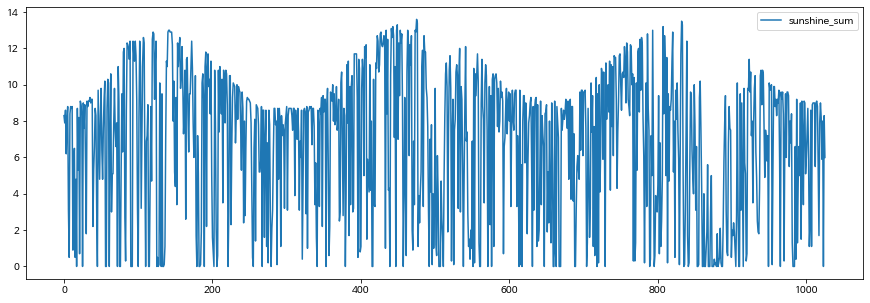

In [76]:
train[['sunshine_sum']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

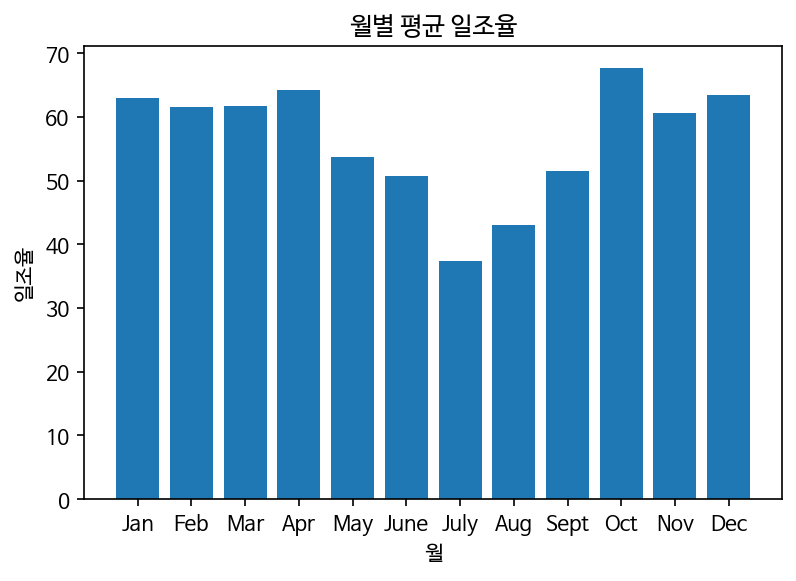

In [77]:
# 관찰 : 10월이 가장 높고 7월이 가장 낮다.
# 강수량과의 상관관계가 어떨지 궁금하다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['sunshine_rate'][1],
     train.groupby('month').mean()['sunshine_rate'][2],
     train.groupby('month').mean()['sunshine_rate'][3],
     train.groupby('month').mean()['sunshine_rate'][4],
     train.groupby('month').mean()['sunshine_rate'][5],
     train.groupby('month').mean()['sunshine_rate'][6],
     train.groupby('month').mean()['sunshine_rate'][7],
     train.groupby('month').mean()['sunshine_rate'][8],
     train.groupby('month').mean()['sunshine_rate'][9],
     train.groupby('month').mean()['sunshine_rate'][10],
     train.groupby('month').mean()['sunshine_rate'][11],
     train.groupby('month').mean()['sunshine_rate'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('일조율')
plt.title('월별 평균 일조율')
plt.bar(x, y)
plt.show()

### 평균풍속 분포

In [78]:
train['wind_mean'].describe()

count    1026.000000
mean        2.024464
std         0.683260
min         0.600000
25%         1.600000
50%         1.900000
75%         2.400000
max         4.800000
Name: wind_mean, dtype: float64

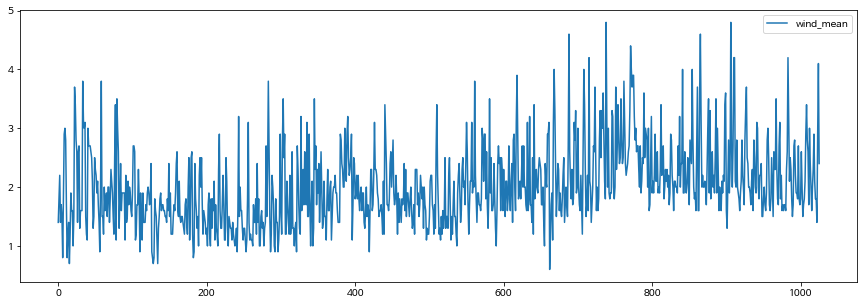

In [79]:
train[['wind_mean']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

In [80]:
train.groupby('month').mean()[['wind_mean']]

,wind_mean
month,
1,1.926882
2,2.079268
3,2.238667
4,2.304938
5,2.083133
6,2.002985
7,1.896667
8,1.871739
9,2.028409


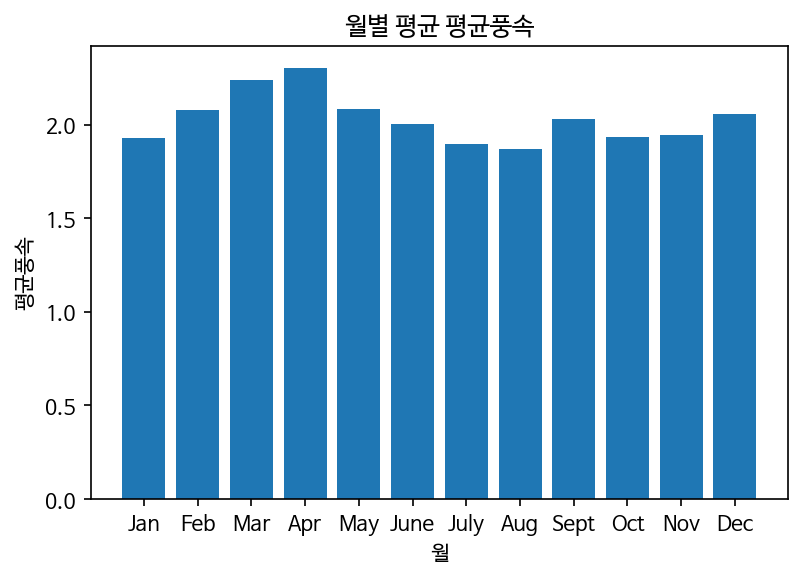

In [81]:
# 관찰 : 4월이 가장 빠르다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['wind_mean'][1],
     train.groupby('month').mean()['wind_mean'][2],
     train.groupby('month').mean()['wind_mean'][3],
     train.groupby('month').mean()['wind_mean'][4],
     train.groupby('month').mean()['wind_mean'][5],
     train.groupby('month').mean()['wind_mean'][6],
     train.groupby('month').mean()['wind_mean'][7],
     train.groupby('month').mean()['wind_mean'][8],
     train.groupby('month').mean()['wind_mean'][9],
     train.groupby('month').mean()['wind_mean'][10],
     train.groupby('month').mean()['wind_mean'][11],
     train.groupby('month').mean()['wind_mean'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('평균풍속')
plt.title('월별 평균 평균풍속')
plt.bar(x, y)
plt.show()

### 최대풍속 분포

In [82]:
train['wind_max'].describe()

count    1026.000000
mean        4.371637
std         1.197919
min         1.600000
25%         3.500000
50%         4.200000
75%         5.100000
max         9.800000
Name: wind_max, dtype: float64

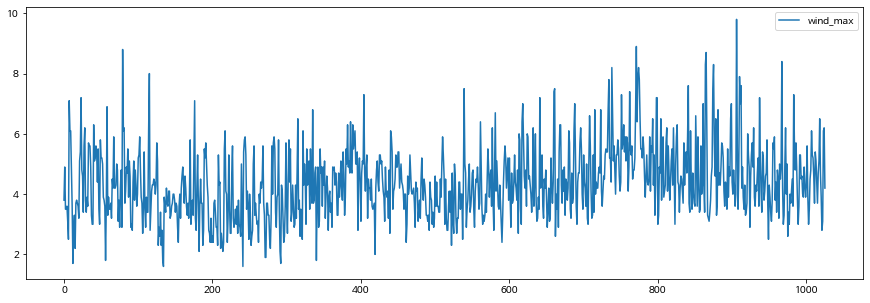

In [83]:
train[['wind_max']].plot(figsize=(15,5))
plt.show()

#### 월별 분포

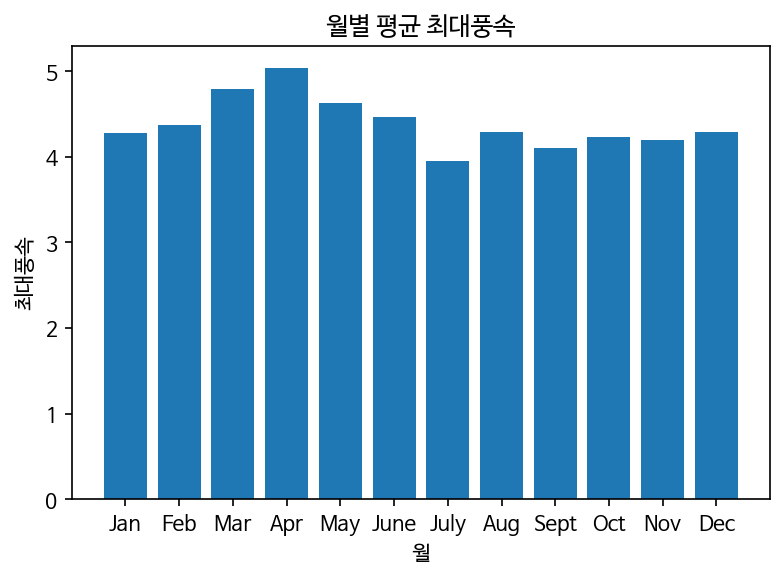

In [84]:
# 관찰 : 4월이 가장 빠르다.
x = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 
     'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
y = [train.groupby('month').mean()['wind_max'][1],
     train.groupby('month').mean()['wind_max'][2],
     train.groupby('month').mean()['wind_max'][3],
     train.groupby('month').mean()['wind_max'][4],
     train.groupby('month').mean()['wind_max'][5],
     train.groupby('month').mean()['wind_max'][6],
     train.groupby('month').mean()['wind_max'][7],
     train.groupby('month').mean()['wind_max'][8],
     train.groupby('month').mean()['wind_max'][9],
     train.groupby('month').mean()['wind_max'][10],
     train.groupby('month').mean()['wind_max'][11],
     train.groupby('month').mean()['wind_max'][12],
     ]
plt.figure(dpi=150)
plt.xlabel('월')
plt.ylabel('최대풍속')
plt.title('월별 평균 최대풍속')
plt.bar(x, y)
plt.show()

## 상관 관계 분석

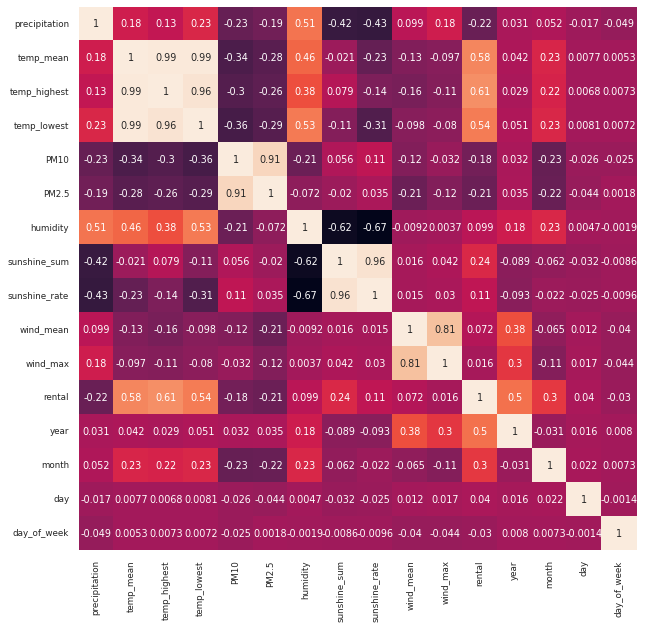

In [85]:
train_corr = train.corr()
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(train_corr, annot=True, cbar=False)
plt.show()

In [86]:
y = train.rental
X = train.drop(['rental', 'PM2.5'], axis=1)

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [88]:
xgb = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('MAE : ', mae)

MAE :  4422.294789138349


In [89]:
train = shuffle(train)
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
562,0.0,20.0,24.6,16.9,12.0,6.0,51.1,9.0,73.8,2.2,5.0,92006.0,2019,9,23,0
25,0.0,-14.8,-10.7,-17.8,28.0,18.0,34.9,0.0,0.0,2.6,4.6,3116.0,2018,1,26,4
188,0.0,25.1,29.6,20.1,12.0,7.0,55.8,9.2,70.8,1.5,2.8,48427.0,2018,9,2,6


In [90]:
y = train.rental
X = train.drop(['rental', 'PM2.5'], axis=1)

In [91]:
test_model = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:squarederror',
                       silent=1,
                       subsample=0.7)
test_model.fit(X, y)

test = test.drop('PM2.5', axis=1)

submission['rental'] = test_model.predict(test)

In [92]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submissions/submission-2022-06-17-ik.csv', index=False)

## submission result
- pm.25 제외하고 학습시킨 모델의 성능이 더 좋다.

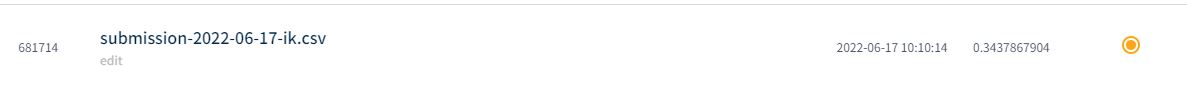

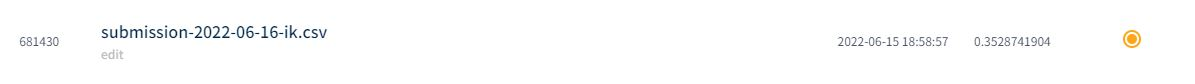